# XGBoost model

In [1]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

import modify_dataset as md

In [21]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [3]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [4]:
df = df.drop(['NumberOfCustomers'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [5]:
df = df[df.IsOpen == 1]

In [6]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [7]:
#only for pca
df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
df.shape

(433958, 43)

In [9]:
train = md.get_fake_train(df)

In [10]:
train.shape

(397047, 43)

In [11]:
test = md.get_fake_test(df)
test.shape

(36911, 43)

In [16]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('Events_Thunderstorm')
#features.remove('Events_Fog')
features.remove('D_DayOfweek')
features.remove('Date')
print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']


C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


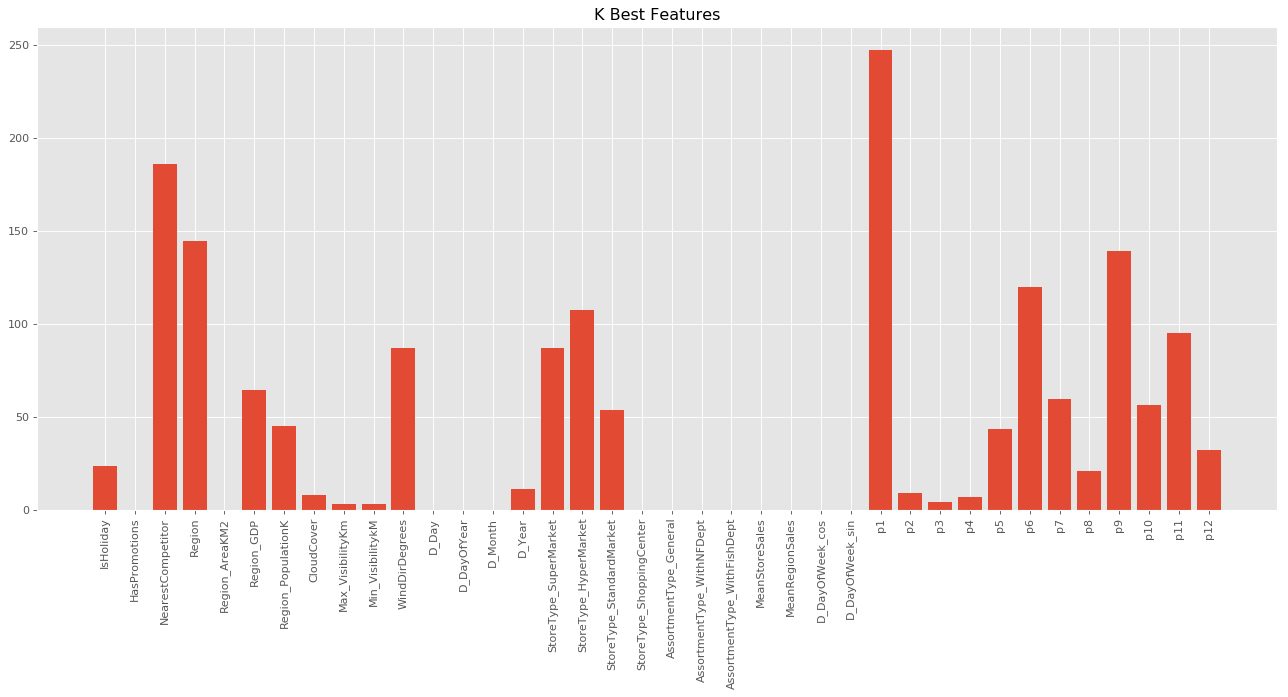

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Perform feature selection
selector = SelectKBest(f_regression, k=20)
selector.fit(train[features], train['NumberOfSales'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores for each feature 
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title('K Best Features')
plt.show()

### Selecting predictive features 

In [104]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('Events_Thunderstorm')
#features.remove('Events_Fog')
features.remove('D_DayOfweek')
features.remove('Date')
print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'Mean_month_sale']


In [105]:
features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')
#4.5%

features.remove('p8')
features.remove('p10')
#4.2%

In [106]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [107]:
#from xgboost.sklearn import XGBRegressor # wrapper
## XGB with sklearn wrapper
## the same parameters as for xgboost model
#params_sk = {'max_depth': 8, 
#            'n_estimators': 100, # the same as num_rounds in xgboost
#            'objective': 'reg:linear', 
#            'subsample': 1.0, 
#            'colsample_bytree': 0.3, 
#            'learning_rate': 0.1, 
#            'seed': 23}     
#
#skrg = XGBRegressor(**params_sk)
#
#skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

In [108]:
#import scipy.stats as st
#
#params_grid = {  
#    'learning_rate': st.uniform(0.001, 0.2),
#    'max_depth': list(range(6, 20, 2)),
#    'gamma': st.uniform(0, 40),
#    'reg_alpha': st.expon(0, 40)}
#
#search_sk = RandomizedSearchCV(skrg, params_grid, cv = 3, verbose=2) # 3 fold cross validation
#search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#
## best parameters
#print(search_sk.best_params_); print(search_sk.best_score_)

### Hyperparameters tuning
The result was obtained using 0.3 of the train set (22 months) at random.
#### Result
{'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}
0.8171277539145538

In [109]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [110]:
X_train.shape

(377194, 44)

In [111]:
X_test.shape

(19853, 44)

In [112]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [113]:
#Using tuned params
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "seed": 23,
          #"gamma": 14.5573974470,  #added as a test
          #"reg_alpha": 11.010959407512171
          }

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [114]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33907	train-rmse:6.33626
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07681	train-rmse:5.07421
[2]	test-rmse:4.06756	train-rmse:4.06514
[3]	test-rmse:3.26132	train-rmse:3.25898
[4]	test-rmse:2.61353	train-rmse:2.61155
[5]	test-rmse:2.09848	train-rmse:2.09668
[6]	test-rmse:1.68818	train-rmse:1.68642
[7]	test-rmse:1.35724	train-rmse:1.3558
[8]	test-rmse:1.09598	train-rmse:1.0948
[9]	test-rmse:0.885922	train-rmse:0.885021
[10]	test-rmse:0.72197	train-rmse:0.721242
[11]	test-rmse:0.592795	train-rmse:0.592217
[12]	test-rmse:0.49355	train-rmse:0.493082
[13]	test-rmse:0.415331	train-rmse:0.415088
[14]	test-rmse:0.349796	train-rmse:0.349914
[15]	test-rmse:0.304535	train-rmse:0.304722
[16]	test-rmse:0.270835	train-rmse:0.271113
[17]	test-rmse:0.24585	train-rmse:0.246246
[18]	test-rmse:0.227991	train-rmse:0.228385
[19]	test-rmse:0.215297	train-rmse:0.215417
[20]	tes

### Plotting Trees

In [115]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['figure.figsize'] = [40.0,20.0]
#plt.rcParams['figure.dpi']=400
#plt.rcParams.update({'font.size': 30})

In [116]:
from xgboost import plot_tree
#plot_tree(gbm)


In [117]:
#xgb.to_graphviz(gbm, num_trees=0, rankdir='LR', **{'size':str(10)})

In [118]:
#xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(10)})

### Validating

In [119]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.4515535096412574


RMSE

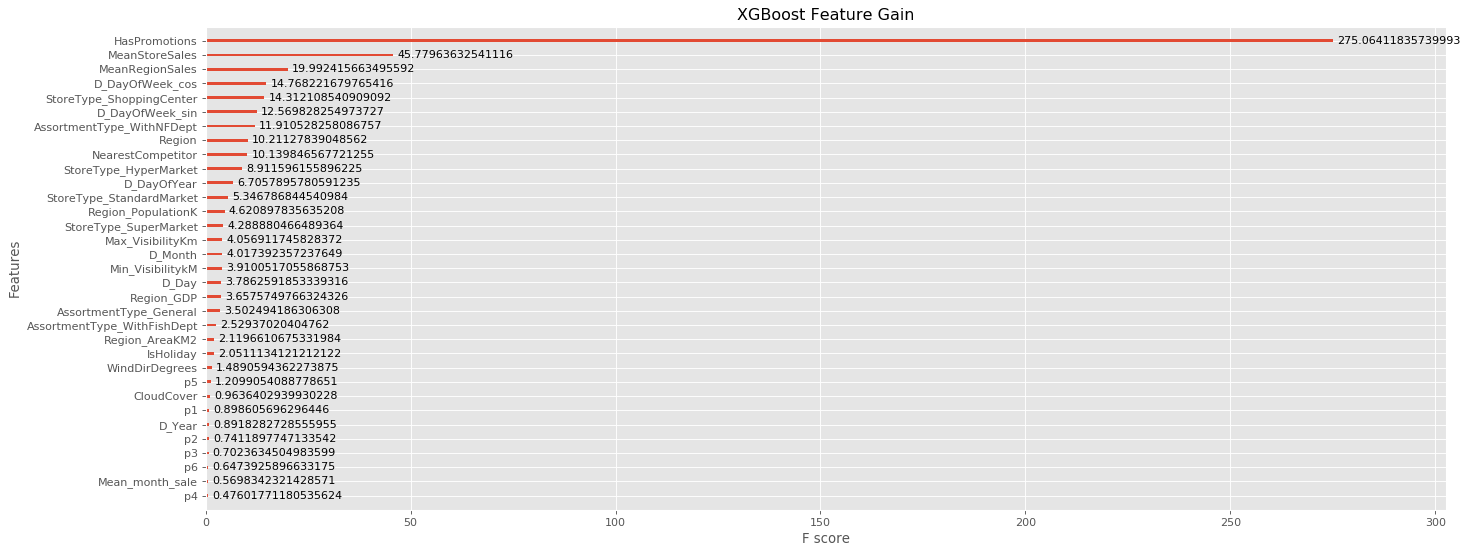

In [127]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

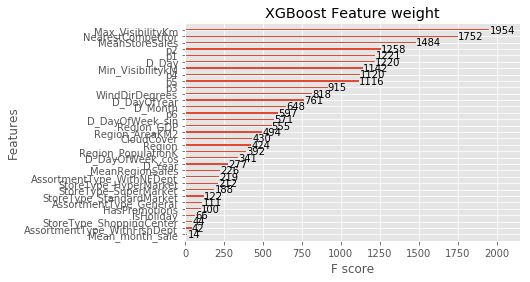

In [121]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

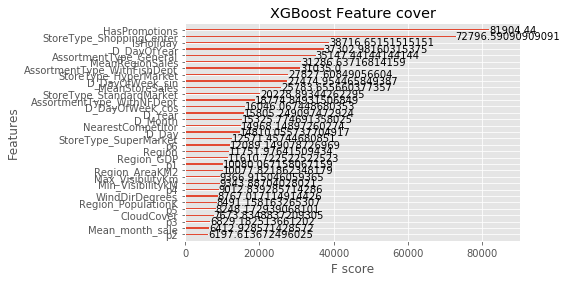

In [122]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [123]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [124]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [125]:
from BIP import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.047519115298537765


In [318]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [319]:
diff.head(15).T

670     974.339355
671    2787.290527
672     322.897461
674    1992.547363
675    -596.341309
677    -741.625977
678     108.270996
679     436.239746
680    -461.470703
681     435.550781
682    -368.837402
684     326.560547
685    1553.171875
686     434.443359
687     387.444336
dtype: float32

In [320]:
diff.mean()

22.574554443359375

In [54]:
train_probs.shape

(36911,)

In [55]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [56]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [57]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [58]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.19567676584967392


In [59]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


In [60]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


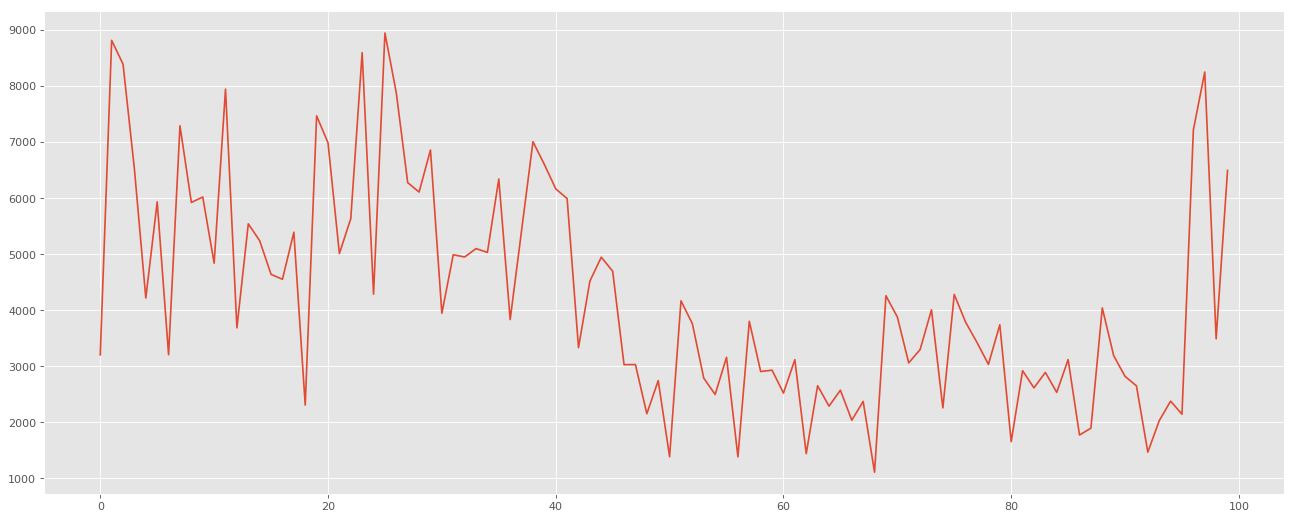

In [61]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

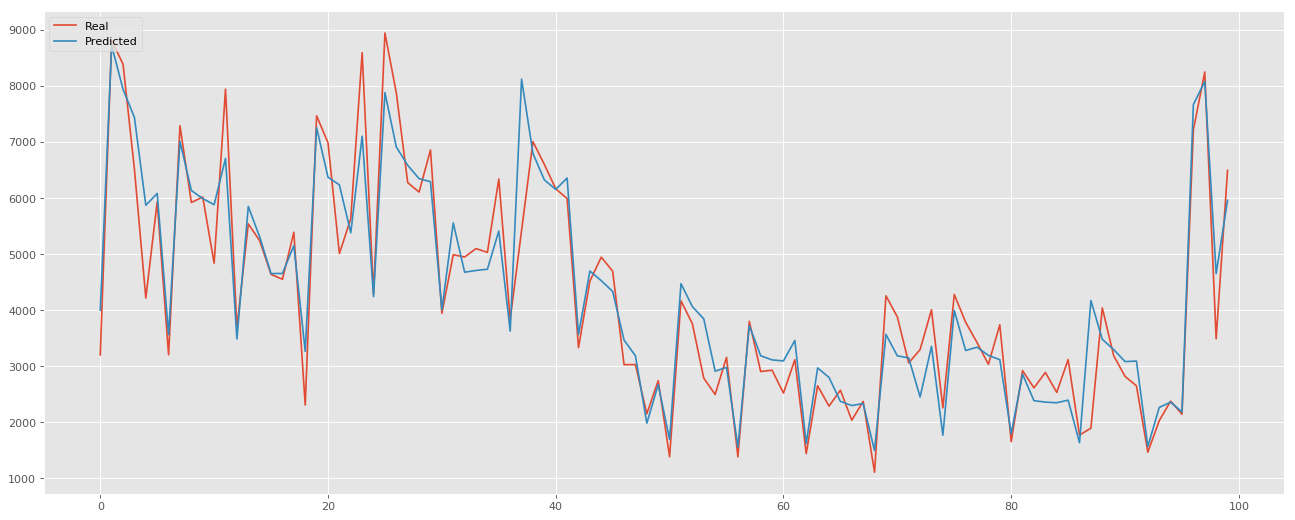

In [62]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

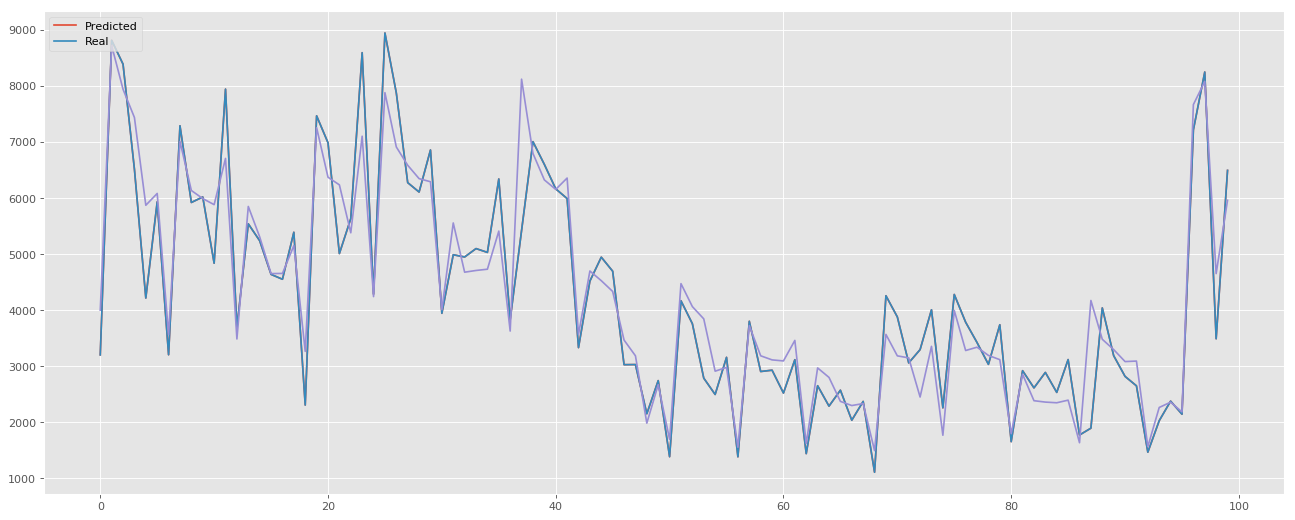

In [63]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [64]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y